## 1 - Simple regression model in TensorFlow 2.0

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.get_logger().setLevel('ERROR')

print(tf.__version__)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
2.6.0-dev20210412


In [8]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/")
dataset_path

'/Users/niujie/.keras/datasets/auto-mpg.data'

In [9]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

In [10]:
# Drop NA values
dataset = dataset.dropna()

In [11]:
# turn origin into a one-hot encoded vector

origin = dataset.pop('Origin')

In [12]:
dataset['USA'] = (origin == 1) * 1.0    # cast series to float
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

/Users/niujie/tensorflow-venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/niujie/tensorflow-venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/niujie/tensorflow-venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  USA  Europe  Japan  
393          82  1.0     0.0    0.0  
394          82  0.0     1.0    0.0  
395          82  1.0     0.0    0.0  
396          82  1.0     0.0    0.0  
397          82  1.0     0.0    0.0

In [13]:
# Split the dataset into an 80/20 train/test division
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Explore data

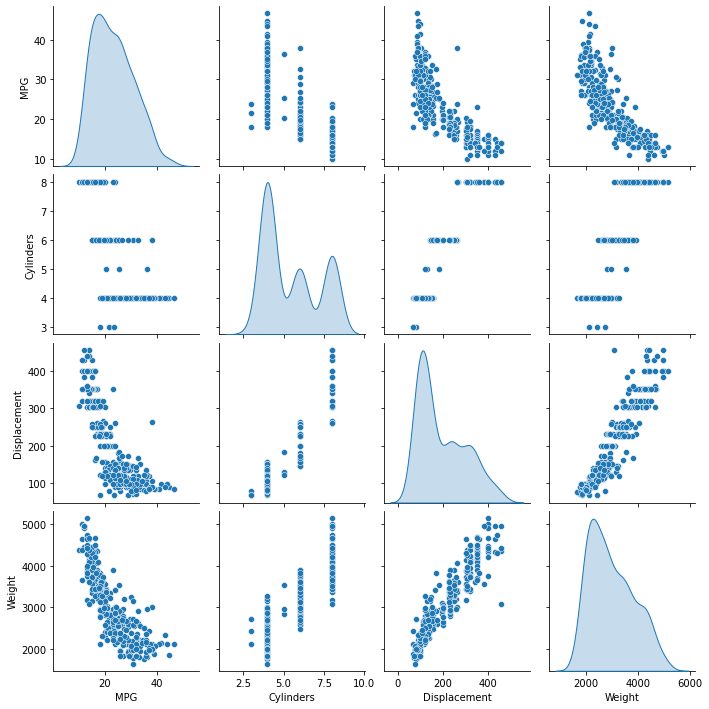

In [14]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [15]:
train_stats =train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe           0.00     1.0  
Japan            0.00     1.0

In [16]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## Normal transform

In [17]:
def norm(x: pd.DataFrame) -> pd.DataFrame:
    """Norm all columns to zero mean and unit standard deviation."""
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [20]:
def build_model() -> tf.keras.Model:
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

In [21]:
model = build_model()

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [23]:
normed_train_data.shape

(314, 9)

In [24]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.2544558 ],
       [0.19125381],
       [0.5607853 ],
       [0.3481667 ],
       [0.5134902 ],
       [0.11542366],
       [0.53908914],
       [0.55140245],
       [0.15429872],
       [0.16308272]], dtype=float32)

In [25]:
model.predict(example_batch)

array([[0.2544558 ],
       [0.19125381],
       [0.5607853 ],
       [0.3481667 ],
       [0.5134902 ],
       [0.11542366],
       [0.53908914],
       [0.55140245],
       [0.15429872],
       [0.16308272]], dtype=float32)

In [26]:
model2 = build_model()

model2.predict(example_batch)

array([[-0.3928637 ],
       [-0.42062768],
       [ 0.25381362],
       [-0.65489686],
       [-0.31992   ],
       [-0.4174146 ],
       [-0.3517052 ],
       [ 0.12119097],
       [-0.17489219],
       [-0.46868068]], dtype=float32)

## Train the network

In [27]:
class printDot(keras.callbacks.Callback):
    """
    Display training progress by printing a single dot for
    each completed epoch.
    """
    def on_epoch_end(self, epoch, logs) -> None:
        """
        `on_epoch_end` hook to take the epoch number and logs.
        This will run whenever the training loop finishes an epoch.
        """
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[printDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [28]:
history

In [29]:
dir(history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_implements_predict_batch_hooks',
 '_implements_test_batch_hooks',
 '_implements_train_batch_hooks',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_supports_tf_logs',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [30]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

loss        mae         mse    val_loss    val_mae     val_mse
0  545.993164  22.066328  545.993164  524.657166  21.551964  524.657166
1  484.339661  20.630707  484.339661  459.614197  19.961647  459.614197
2  425.973724  19.144690  425.973724  393.320618  18.204792  393.320618
3  364.752167  17.463987  364.752167  325.490051  16.231890  325.490051
4  302.371277  15.619715  302.371277  257.980713  14.120688  257.980713

In [31]:
hist_df['epoch'] = history.epoch
hist_df.tail()

loss       mae       mse  val_loss   val_mae   val_mse  epoch
995  2.438272  1.044484  2.438272  9.052894  2.372787  9.052894    995
996  2.287675  0.981264  2.287675  8.094198  2.220420  8.094198    996
997  2.297898  1.002661  2.297898  8.409054  2.269199  8.409054    997
998  2.414346  0.998407  2.414346  8.223638  2.257792  8.223638    998
999  2.192615  0.953082  2.192615  8.912223  2.373065  8.912223    999

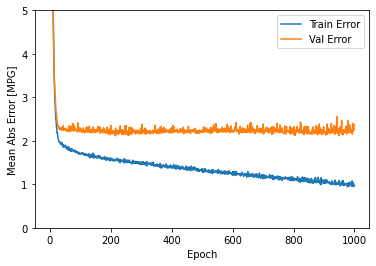

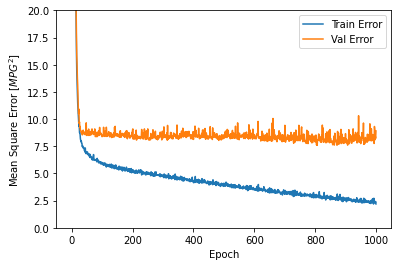

In [33]:
def plot_history(history: tf.keras.callbacks.History) -> None:
    """
    Plot training vs validation MAE and MSE over epoch.
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0, 5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0, 20])
    plt.legend()
    plt.show()

plot_history(history)

In [34]:
# How about if we predict on our example batch again?

model.predict(example_batch)

array([[27.320412],
       [22.86172 ],
       [11.183157],
       [37.150696],
       [35.54459 ],
       [19.70863 ],
       [38.217617],
       [29.390667],
       [19.837526],
       [20.087763]], dtype=float32)

In [35]:
# And are those predictions stable/deterministic?

model.predict(example_batch)

array([[27.320412],
       [22.86172 ],
       [11.183157],
       [37.150696],
       [35.54459 ],
       [19.70863 ],
       [38.217617],
       [29.390667],
       [19.837526],
       [20.087763]], dtype=float32)

In [36]:
# And how does that compare to the completely untrained model?

model2.predict(example_batch)

array([[-0.3928637 ],
       [-0.42062768],
       [ 0.25381362],
       [-0.65489686],
       [-0.31992   ],
       [-0.4174146 ],
       [-0.3517052 ],
       [ 0.12119097],
       [-0.17489219],
       [-0.46868068]], dtype=float32)

In [37]:
# How about if we were to train that network? Would we get the same results for the same input?

model2.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[printDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [38]:
list(zip(model.predict(example_batch), model2.predict(example_batch)))

[(array([27.320412], dtype=float32), array([28.248138], dtype=float32)),
 (array([22.86172], dtype=float32), array([23.755344], dtype=float32)),
 (array([11.183157], dtype=float32), array([12.607808], dtype=float32)),
 (array([37.150696], dtype=float32), array([37.94974], dtype=float32)),
 (array([35.54459], dtype=float32), array([35.365047], dtype=float32)),
 (array([19.70863], dtype=float32), array([19.247734], dtype=float32)),
 (array([38.217617], dtype=float32), array([38.06502], dtype=float32)),
 (array([29.390667], dtype=float32), array([30.03883], dtype=float32)),
 (array([19.837526], dtype=float32), array([20.590937], dtype=float32)),
 (array([20.087763], dtype=float32), array([22.378529], dtype=float32))]

In [39]:
# Waht are the actual differences in prediction value?

model.predict(example_batch) - model2.predict(example_batch)

array([[-0.92772675],
       [-0.89362526],
       [-1.4246511 ],
       [-0.79904556],
       [ 0.17954254],
       [ 0.46089554],
       [ 0.15259552],
       [-0.64816284],
       [-0.75341034],
       [-2.2907658 ]], dtype=float32)

## Early stopping

We can prevent overfitting to some degree via *early stopping*, wherein we monitor improvement in some metric and end the training routine after some tolerance of no improvement. `tf.keras` provides this for us as a built-in callback object.


...........................................

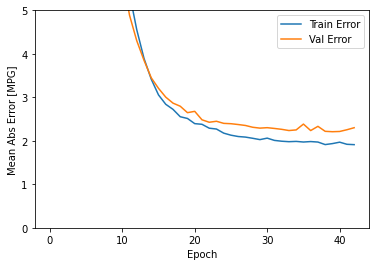

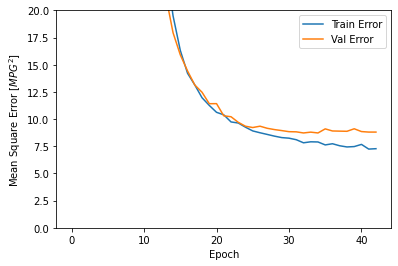

In [41]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# In this example, we'll monitor the validation loss for improvement and tolerate 10 epochs of stagnation.

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stop, printDot()]
)

plot_history(history)


..........................................................................................

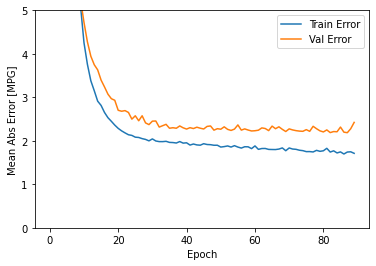

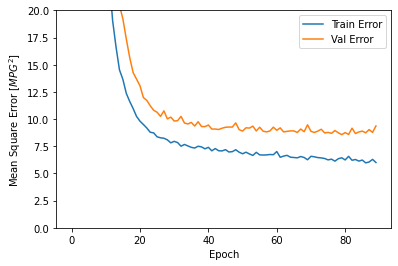

In [42]:
model2 = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history2 = model2.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stop, printDot()]
)

plot_history(history2)

In [43]:
len(history.epoch), len(history2.epoch)

(43, 90)

In [44]:
model.predict(example_batch) - model2.predict(example_batch)

array([[-0.05993271],
       [ 0.09989166],
       [-0.04717255],
       [ 1.1113739 ],
       [ 0.4718933 ],
       [ 0.71095467],
       [ 0.3974228 ],
       [-0.12807846],
       [-0.5223999 ],
       [ 1.7309246 ]], dtype=float32)

In [45]:
loss1, mae1, mse1 = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae1))

3/3 - 0s - loss: 5.9438 - mae: 1.8276 - mse: 5.9438
Testing set Mean Abs Error:  1.83 MPG


In [47]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae2))

3/3 - 0s - loss: 6.1455 - mae: 1.8583 - mse: 6.1455
Testing set Mean Abs Error:  1.86 MPG


In [48]:
(mae1 - mae2) / mae1

-0.016801393778223064

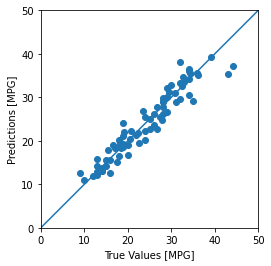

In [49]:
test_predictions1 = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions1)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

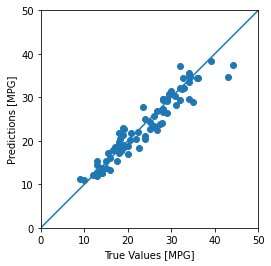

In [50]:
test_predictions2 = model2.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions2)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

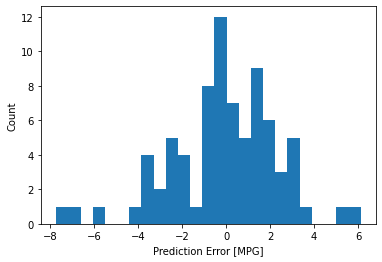

In [51]:
error1 = test_predictions1 - test_labels
plt.hist(error1, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

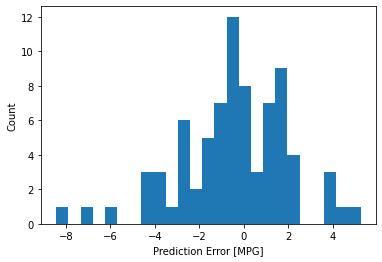

In [52]:
error2 = test_predictions2 - test_labels
plt.hist(error2, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

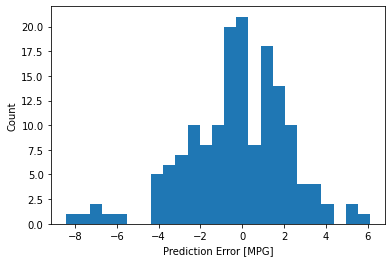

In [53]:
combined_errors = pd.concat([error1, error2])
plt.hist(combined_errors, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

### Takeaways:

- Neural networks are subject to *uncertainty* in their weights due to the random nature of their initialization and the selection of training/validation data
- This can lead to different weight selections in repeated applications of the same training routine.
- This property is present, even when tricks like Early Stopping are used to control for overfitting.

## 2 - Simple regression model in TensorFlow 2.0...probabilistically.

In [70]:
import pathlib
from typing import Any, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

tf.get_logger().setLevel('ERROR')

print(tf.__version__)

2.6.0-dev20210412


In [55]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/")
dataset_path

'/Users/niujie/.keras/datasets/auto-mpg.data'

In [56]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

In [57]:
# Drop NA values
dataset = dataset.dropna()

In [58]:
# turn origin into a one-hot encoded vector

origin = dataset.pop('Origin')

In [59]:
dataset['USA'] = (origin == 1) * 1.0    # cast series to float
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  USA  Europe  Japan  
393          82  1.0     0.0    0.0  
394          82  0.0     1.0    0.0  
395          82  1.0     0.0    0.0  
396          82  1.0     0.0    0.0  
397          82  1.0     0.0    0.0

In [60]:
# Split the dataset into an 80/20 train/test division
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [61]:
train_stats =train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe           0.00     1.0  
Japan            0.00     1.0

In [62]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [63]:
def norm(x: pd.DataFrame) -> pd.DataFrame:
    """Norm all columns to zero mean and unit standard deviation."""
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Do it probabilistically!

Going to replace the first `Dense` layer with one that's probabilistic.

In [64]:
def build_model() -> tf.keras.Model:
    model = keras.Sequential([
        tfp.layers.DenseVariational(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

`DenseVariational`? This is a vanilla densely-connected neural network layer that, rather than fitting point estimates, fits distributions over its weights using *variational inference*. It is a way to update prior Bayesian beliefs about a distribution in response to observed data that's more computationally efficient than Markov Chain Monte Carlo sampling.

%%HTML
<iframe src="https://ermongroup.github.io/cs228-notes/inference/variational/" width="900" height="500"></iframe>

In [65]:
model = build_model()

TypeError: __init__() missing 2 required positional arguments: 'make_posterior_fn' and 'make_prior_fn'

Well, maybe not quite that easy.

## Specify trainable priors and posterior functions.

In order to work with the `DenseVariational` layer, we need to provide it with a function to make its posterior (learned) distribution of weights and a prior distribution to apply to the weights in the absence of any observed data.

In [66]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: Any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

In [67]:
def prior_trainable(kernel_size: int, bias_size: int, dtype: Any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),   # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

In [71]:
def build_model() -> tf.keras.Model:
    model = keras.Sequential([
        tfp.layers.DenseVariational(64, activation='relu', 
                                    input_shape=[len(train_dataset.keys())],
                                    make_posterior_fn=posterior_mean_field,
                                    make_prior_fn=prior_trainable),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

model = build_model()

In [72]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_1 (DenseVa (None, 64)                1920      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


In [73]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.85745263],
       [ 0.31077957],
       [ 2.413654  ],
       [ 2.0329723 ],
       [ 2.2375455 ],
       [ 0.34941304],
       [ 2.2405472 ],
       [ 3.882933  ],
       [-0.17893082],
       [ 3.0673814 ]], dtype=float32)

In [74]:
model.predict(example_batch)

array([[ 2.151127  ],
       [ 2.597422  ],
       [-0.52247775],
       [ 3.0756402 ],
       [ 3.9923103 ],
       [ 1.1209145 ],
       [ 4.559736  ],
       [ 2.3236485 ],
       [ 1.100946  ],
       [ 4.541734  ]], dtype=float32)

They are different! The predictions through the untrained model aren't the same, even though they're going through the same network.

In [76]:
model.layers[0]

The first layer is this `DenseVariational` layer from `tensorflow_probability`. What's happening here is that the model isn't learning weights for that layer (and hasn't initialized them). Rather, it's trying to learn *distributions* over the weights. We have initialized these to be normal distributions with mean 0 and standard deviation 1, and each time we pass a prediction through the network, the actual weights used for that prediction are each *random draws* from the distributions that describe them.

In [77]:
class printDot(keras.callbacks.Callback):
    """
    Display training progress by printing a single dot for
    each completed epoch.
    """
    def on_epoch_end(self, epoch, logs) -> None:
        """
        `on_epoch_end` hook to take the epoch number and logs.
        This will run whenever the training loop finishes an epoch.
        """
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=[printDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [78]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae        mse   val_loss   val_mae    val_mse  epoch
995  19.146599  3.019753  14.507557  18.385317  3.168013  16.263233    995
996  14.491129  2.852847  13.717486  17.197887  2.823122  13.384533    996
997  14.624907  2.648162  12.005547  16.713411  3.144102  15.670100    997
998  20.216785  3.080619  16.960072  18.901777  2.906950  14.705516    998
999  14.102901  2.627443  11.776713  13.953687  2.443083  10.825706    999

The errors are a bit higher than they were with the previous network, but note the difference between the training and validation losses. They're very close to one another, whereas before we were hopelessly overfit.

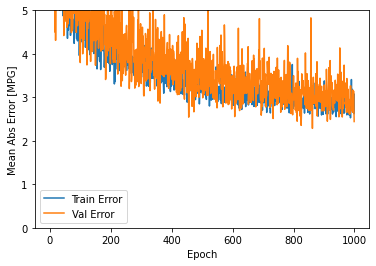

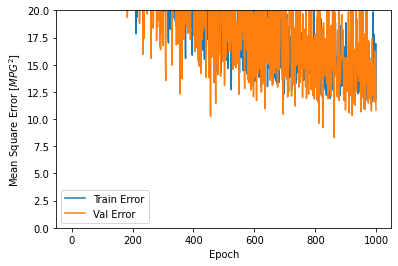

In [105]:
def plot_history(hist: pd.DataFrame) -> None:
    """
    Plot training vs validation MAE and MSE over epoch.
    """
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0, 5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0, 20])
    plt.legend()
    plt.show()

plot_history(hist)

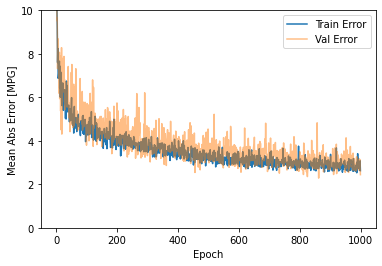

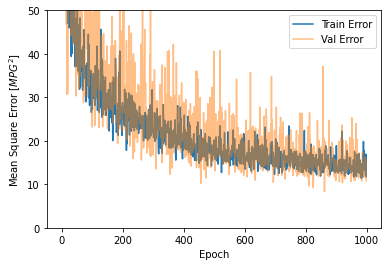

In [106]:
def plot_history(hist: pd.DataFrame) -> None:
    """
    Plot training vs validation MAE and MSE over epoch.
    """
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], alpha=0.5, label='Val Error')
    plt.ylim([0, 10])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], alpha=0.5, label='Val Error')
    plt.ylim([0, 50])
    plt.legend()
    plt.show()

plot_history(hist)

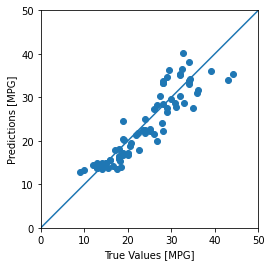

In [81]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

And what if we do it again?

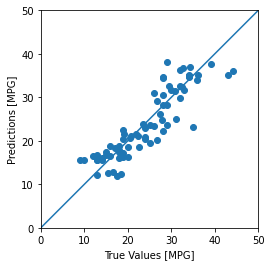

In [82]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

The dots moved! TensorFlow Probability is transparently drawing new samples from the distributions we've trained over our network's weights, and it's interacting completely seamlessly with the `tf.keras.Model` predict method.

We can even ask the model to give us a sample of predictions from each incoming x and use that to give us quantified estimates of its uncertainty.

In [83]:
# Use a list comprehension to predict over each test instance 100 times.
yhats = [model.predict(normed_test_data).flatten() for _ in range(100)]

In [84]:
df = pd.DataFrame(yhats).T
df['y'] = test_labels.values

In [85]:
df.head()

0          1          2          3          4          5  \
0  17.269770  16.961885  13.317101  20.235306  15.077505  19.211563   
1  15.752362  13.068328  10.416280  16.974470  14.835698  17.535572   
2  15.306684  14.897275   9.812816  15.963827  16.018183  17.110321   
3  19.849243  25.635796  23.615181  23.533154  23.650913  23.938725   
4  18.227913  18.673655  16.163174  19.335686  18.750427  19.463272   

           6          7          8          9  ...         91         92  \
0  12.967432  15.389771  15.850799  15.226766  ...  14.865384  19.124249   
1  12.545315  12.482614  14.395729  14.795393  ...  13.794715  14.314434   
2  15.323250  11.897733  14.502273  15.867146  ...  15.742504  14.446864   
3  27.900375  18.805561  26.984720  28.153555  ...  20.039865  22.830114   
4  18.958071  17.107162  18.347250  17.951462  ...  16.937006  17.914818   

          93         94         95         96         97         98  \
0  14.460992  12.478580  17.460350  11.908484  18.486176  17.264387   
1  14.741821  11.416966  16.054476  12.310464  14.751710  13.641780   
2  17.532434  13.218667  16.029337  14.045171  13.861510  14.885585   
3  25.302437  25.495380  24.468119  21.410492  25.747910  24.190800   
4  18.190500  15.852321  17.667141  15.598312  17.761509  17.239777   

          99     y  
0  16.958664  15.0  
1  13.723011  10.0  
2  13.159492   9.0  
3  23.976528  25.0  
4  19.960863  19.0  

[5 rows x 101 columns]

In [86]:
import itertools

sample_preds = list(itertools.chain.from_iterable([[(j, x[-1]) for j in x if j != x[-1]] for x in df.values]))

In [87]:
sample_preds[:15]

[(17.2697696685791, 15.0),
 (16.961885452270508, 15.0),
 (13.31710147857666, 15.0),
 (20.235305786132812, 15.0),
 (15.077505111694336, 15.0),
 (19.211563110351562, 15.0),
 (12.967432022094727, 15.0),
 (15.389771461486816, 15.0),
 (15.850798606872559, 15.0),
 (15.226765632629395, 15.0),
 (20.92479133605957, 15.0),
 (16.910696029663086, 15.0),
 (17.22072410583496, 15.0),
 (12.170138359069824, 15.0),
 (19.082977294921875, 15.0)]

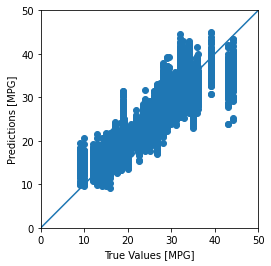

In [88]:
a = plt.axes(aspect='equal')
plt.scatter([x[1] for x in sample_preds], [x[0] for x in sample_preds])
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

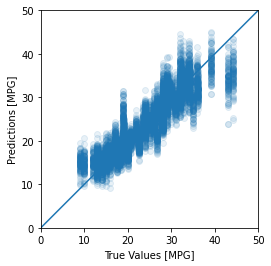

In [89]:
a = plt.axes(aspect='equal')
plt.scatter([x[1] for x in sample_preds], [x[0] for x in sample_preds], alpha=0.1)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

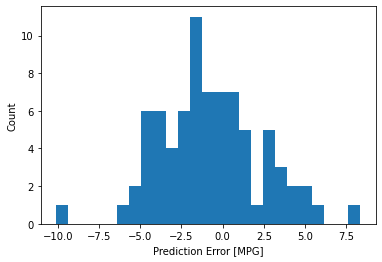

In [90]:
test_predictions = model.predict(normed_test_data).flatten()
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

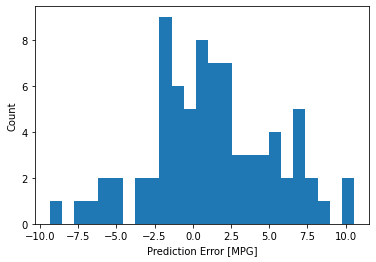

In [92]:
# run this again, get a different set of errors, of course

test_predictions = model.predict(normed_test_data).flatten()
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

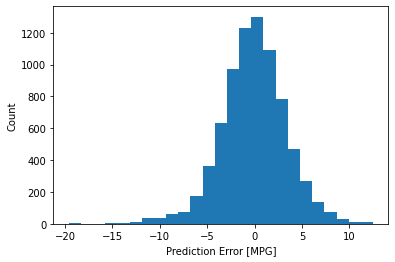

In [94]:
error = [x[0] - x[1] for x in sample_preds]
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Moreover, because the model hasn't shown the tendency to overfit, we can keep training it.

In [95]:
history2 = model.fit(
    normed_train_data,
    train_labels,
    epochs=2_000,
    validation_split=0.2,
    verbose=0,
    callbacks=[printDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [96]:
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
hist2['epoch'] = hist2['epoch'] + EPOCHS
hist2.tail()

loss       mae        mse   val_loss   val_mae    val_mse  epoch
1995  15.507792  2.688512  12.485684  12.445243  2.312046   9.188471   2995
1996  15.817351  2.522095  12.252582  15.179414  3.167973  16.701183   2996
1997  14.088105  2.522668  11.964302  18.779068  2.718975  12.983177   2997
1998  11.944237  2.280862   9.690004  16.261091  2.756082  14.037141   2998
1999  14.889922  2.517370  11.110811  10.061604  2.543566   9.712765   2999

In [102]:
combined_hist = pd.concat([hist, hist2])

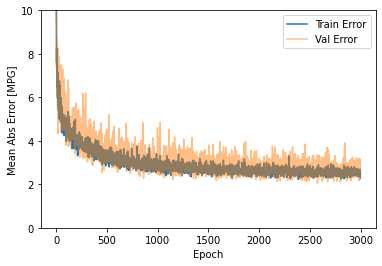

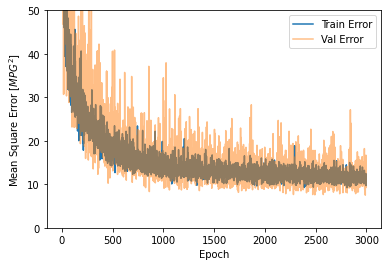

In [107]:
plot_history(combined_hist)

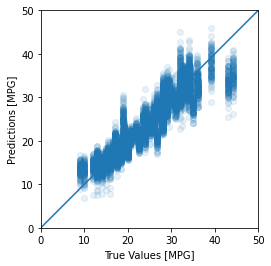

In [109]:
# Use a list comprehension to predict over each test instance 100 times.
yhats = [model.predict(normed_test_data).flatten() for _ in range(100)]

df = pd.DataFrame(yhats).T
df['y'] = test_labels.values

sample_preds = list(itertools.chain.from_iterable([[(j, x[-1]) for j in x if j != x[-1]] for x in df.values]))

a = plt.axes(aspect='equal')
plt.scatter([x[1] for x in sample_preds], [x[0] for x in sample_preds], alpha=0.1)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

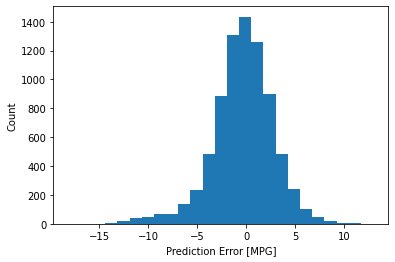

In [110]:
error = [x[0] - x[1] for x in sample_preds]
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

### Takeaways:

- Tensorflow Probability offers a `layers` submodule with a selection of `tf.keras` -compatible neural network layers that are probabilistic.
- These layers interoperate cleanly with existing neural network architectures (up to a point -- sometiems they need explicit priors or other arguments to be provided for them).
- probabilistic neural networks (those with probabilistic layers specifying distributions over their weights) are substantially less prone to overfitting than neural netowrks that merely fit point estimates.
- The `predict` method on these models pulls a *random draw* from the distributions that specify the weights of the model.
- If we run many predictions, we draw a Monte Carlo sample from the model and obtain true estimates of its *uncertainty*.

In [113]:
%%HTML
<iframe src="https://arxiv.org/pdf/1506.02142.pdf" width="900" height="1000"></iframe>